### FOR HW3

In [3]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import stan
import pandas as pd
import arviz as az
import seaborn as sns
import nest_asyncio
from sklearn import linear_model
nest_asyncio.apply()

Define model

In [70]:
program_code = """
data {
    int<lower=1> N;
    int<lower=1> K;
    int<lower=1> T;
    vector[N] charges;
    matrix[N,K] params;
    matrix[K,K] covariance;
    matrix[T,K] test_params;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ inv_gamma(3.0, 1.0);
    alpha ~ normal(0, 10.0);
    beta ~ multi_normal([0.0, 0.0, 0.0], covariance);
    
    // Likelihood
    for (n in 1:N) {
        charges[n] ~ normal(alpha + (params[n] * beta), sigma);
    }
}

generated quantities {
    vector[T] pred_signal;
    for (n in 1:T) {
        pred_signal[n] = normal_rng(alpha + (test_params[n] * beta), sigma);
    }
}

"""

Load data and compile model

In [90]:
samples = pd.read_csv("insurance.csv", delimiter=',')
N = len(samples) # total sample size
K = 3 # number of parameters to estimate

parameters = samples[["age", "bmi", "children"]]
parameters = (parameters - parameters.mean()) / parameters.std()
labels = samples["charges"]
labels = (labels - labels.mean()) / labels.std()

cutoff = int(N*0.7)
training_params, test_params = parameters.iloc[:cutoff], parameters.iloc[cutoff:]
training_labels, test_labels = labels.iloc[:cutoff], labels.iloc[cutoff:]
print(training_params.head())

data = {
    'N' : cutoff,
    'K' : K,
    'T' : len(labels) - cutoff,
    'charges' : training_labels.to_list(),
    'params' : training_params.to_numpy(),
    'covariance' : np.eye(K) * 3.0,
    'test_params' : test_params.to_numpy()
}

model = stan.build(program_code=program_code, data=data)

        age       bmi  children
0 -1.438227 -0.453151 -0.908274
1 -1.509401  0.509431 -0.078738
2 -0.797655  0.383164  1.580335
3 -0.441782 -1.305043 -0.908274
4 -0.512957 -0.292447 -0.908274
Building...


Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [91]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=1000)
results = fit.to_frame()

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  16% (1300/8000)
Sampling:  20% (1600/8000)
Sampling:  24% (1900/8000)
Sampling:  28% (2200/8000)
Sampling:  31% (2500/8000)
Sampling:  35% (2800/8000)
Sampling:  39% (3100/8000)
Sampling:  58% (4600/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_p8ew6zvc/model_53lhr3sl.stan', line 26, column 8 to column 63)
  If this warning occurs sporadically, such as for highly constrained variable typ

In [92]:
az.summary(fit, var_names=['alpha', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.029,0.030,-0.085,0.028,0.0,0.0,5048.0,3158.0,1.0
sigma,0.928,0.022,0.888,0.968,0.0,0.0,5048.0,3350.0,1.0
beta[0],0.300,0.030,0.243,0.356,0.0,0.0,5129.0,3214.0,1.0
beta[1],0.158,0.031,0.100,0.213,0.0,0.0,5298.0,3221.0,1.0
beta[2],0.033,0.031,-0.022,0.092,0.0,0.0,5285.0,3306.0,1.0


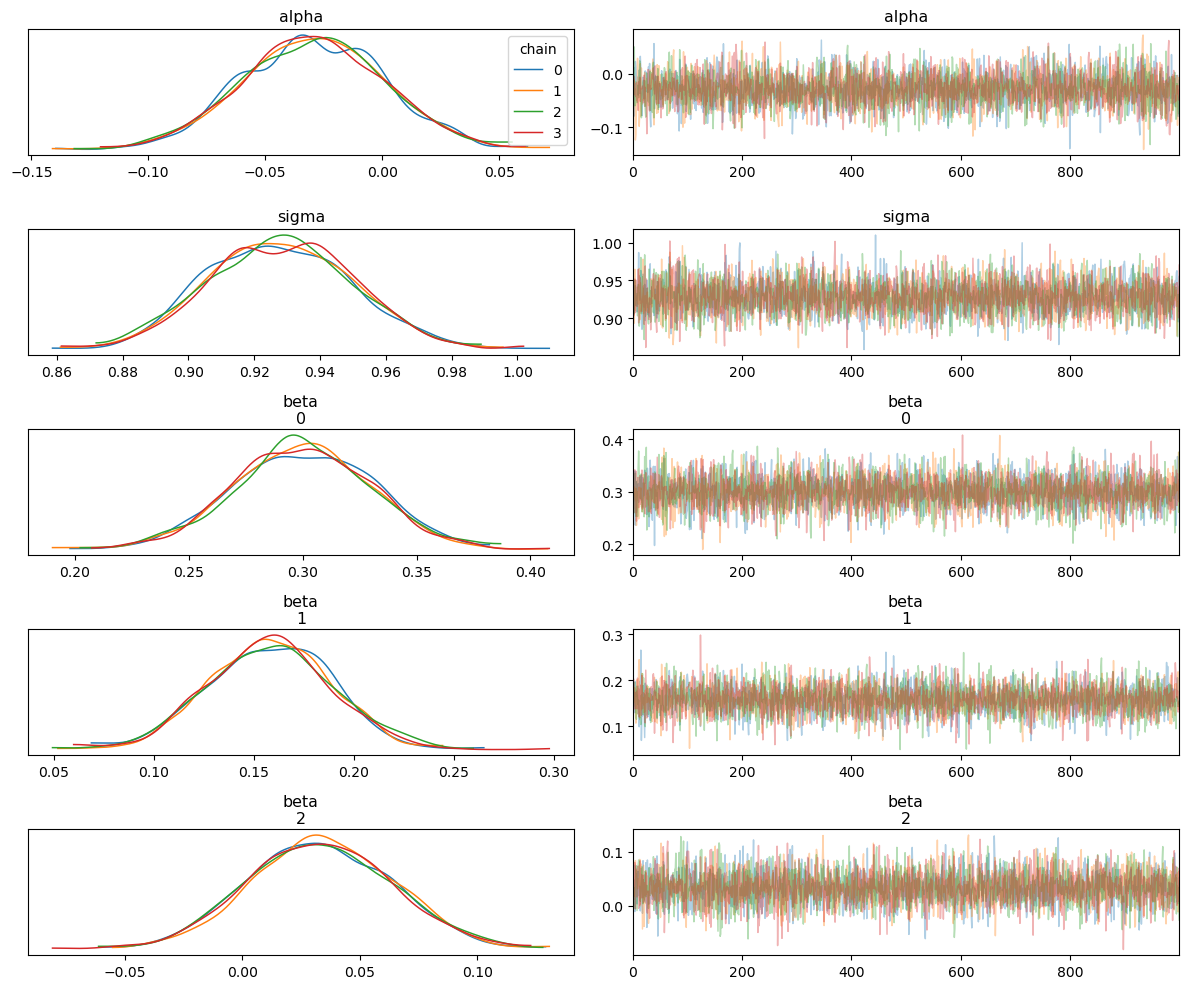

In [94]:
f = az.plot_trace(fit, compact=False, legend=True, var_names=['alpha', 'sigma', 'beta'])
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

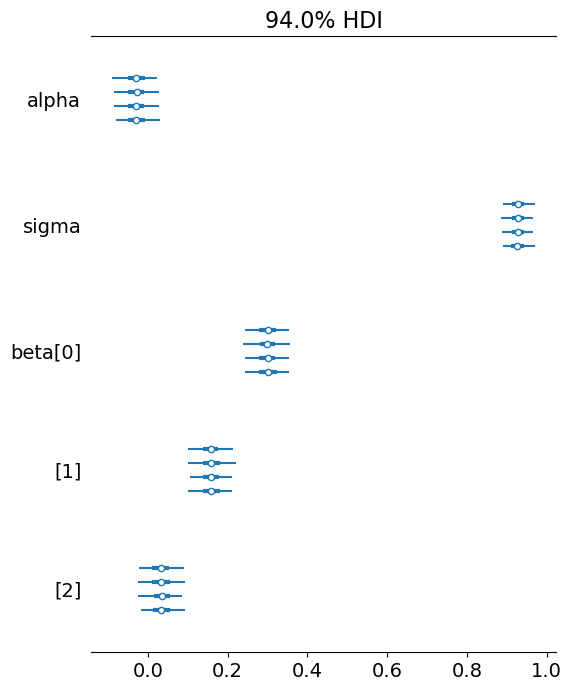

In [95]:
az.plot_forest(fit, var_names=['alpha', 'sigma', 'beta'])

/home/chase/miniconda3/envs/cog/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'RMSE')

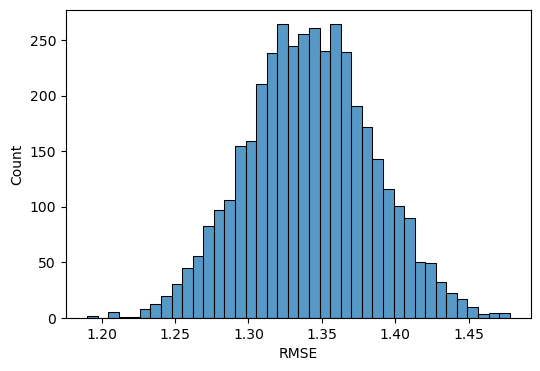

In [97]:
f, ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.sqrt(np.mean((results.iloc[:, 12:] - test_labels.values) ** 2, axis=1)), ax=ax)
ax.set_xlabel("RMSE")